In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [2]:
# !kaggle datasets download -d akrsnv/catdog

 99% 681M/686M [00:09<00:00, 77.0MB/s]
100% 686M/686M [00:09<00:00, 77.4MB/s]


In [4]:
# !mkdir catdog; unzip catdog.zip; mv 'train', 'test' catdog

In [1]:
import os
import re
train_paths = []
test_paths = []
for dirname, _, filenames in os.walk('/content/catdog'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if re.search(r'test', path):
            test_paths.append(path)
        else:
            train_paths.append(path)

In [2]:
test_paths[:5]

['/content/catdog/test/0/270.png',
 '/content/catdog/test/0/267.png',
 '/content/catdog/test/0/263.png',
 '/content/catdog/test/0/256.png',
 '/content/catdog/test/0/273.png']

In [3]:
import numpy as np
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision

In [4]:
def transform_images(image, width=224, height=224):
    transforms = A.Compose(
        [
            A.Resize(width, height),
            A.CLAHE(),
            #A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75)
        ]
    )
    #this is the albumentation return format
    return transforms(image=image)['image']

In [5]:
# there is no label path in this dataset
class CatsAndDogsData(Dataset):

    def __init__(self, image_path_list, augmentations=None):
        self.image_paths = image_path_list
        self.augmentations = augmentations
    
    def __getitem__(self, index):
        if os.path.exists(self.image_paths[index]):
            #read image and lable
            image = cv2.imread(filename=self.image_paths[index])
            #cv2 reads image 
            try:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                ##Augmentations here##
                if self.augmentations:
                    image = self.augmentations(image)
                #pytorch expects image to be in a batch first format
                image = np.transpose(image, (2,0,1)).astype(np.float32)

                if re.search(r'/0/', self.image_paths[index]):
                    label = 0
                else:
                    label = 1
                #return image ands lablel in this format
                return { 
                    'image': torch.tensor(image), 
                    'label': torch.tensor(label) 
                }
            except:
                pass
    
    def __len__(self):
        return len(self.image_paths)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=CatsAndDogsData(train_paths, augmentations=transform_images), batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=CatsAndDogsData(test_paths, augmentations=transform_images), batch_size=64, shuffle=True)

In [8]:
# class VGGNet(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(VGGNet, self).__init__()
#         self.in_channels = in_channels
#         self.num_classes= num_classes
        
#         self.conv_block_64 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Dropout2d(p=0.2)
#         )
#         self.conv_block_128 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Dropout2d(p=0.3)
#         )
#         self.conv_block_256 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Dropout2d(p=0.5)
#         )
#         self.conv_block_512_1 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Dropout2d(p=0.5)
#         )
#         self.conv_block_512_2 = nn.Sequential(
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Dropout2d(p=0.2)
#         )
        
#         self.fcl = nn.Sequential(
#             nn.Linear(512*7*7, 4096),
#             nn.ReLU(),
#             nn.Dropout(p=0.2),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Dropout(p=0.4),
#             nn.Linear(4096, self.num_classes)
#         )
        
#     def forward(self, x):
#         x = self.conv_block_64(x)
#         x = self.conv_block_128(x)
#         x = self.conv_block_256(x)
#         x = self.conv_block_512_1(x)
#         x = self.conv_block_512_2(x)
#         #x = np.reshape(x.shape[0], -1)
#         x = torch.flatten(x,1)
#         x = self.fcl(x)
#         return x


In [9]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(Block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
    self.stride = stride
    
  def forward(self, x):
    identity = x
    
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    
    x += identity
    x = self.relu(x)
    return x

In [10]:
class ResNet(nn.Module):
  """
  image_channels - In case of rgb, this is 3. But in case of greyscale images, this value is 1.
  """
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #ResNet Layers
    self.res_block1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.res_block2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.res_block3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.res_block4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.res_block1(x)
    x = self.res_block2(x)
    x = self.res_block3(x)
    x = self.res_block4(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x



  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels*4:
      identity_downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels*4)
      )

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))
    
    return nn.Sequential(*layers)

In [11]:
resnet50 = [3,4,6,3]

In [12]:
model = ResNet(block=Block,layers=resnet50, image_channels=3, num_classes=1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d

**Testing the NN**

In [13]:
sample = iter(train_loader).next()
print("Input Image Shape: ",sample['image'].shape)
print("label Shape:", sample['label'].shape)
with torch.no_grad():
    sample_pred = model.forward(sample['image'])
print("\nPredicted shape:", sample_pred.shape)
print("\n\nSAMPLE PREDICTION:",sample_pred)
    # print(sample_pred)

Input Image Shape:  torch.Size([64, 3, 224, 224])
label Shape: torch.Size([64])

Predicted shape: torch.Size([64, 1])


SAMPLE PREDICTION: tensor([[-0.3039],
        [-0.1360],
        [ 0.0540],
        [-0.2955],
        [-0.3653],
        [ 0.1686],
        [-0.3124],
        [ 0.6207],
        [-0.3342],
        [-0.3426],
        [-0.3019],
        [-0.2769],
        [ 0.0392],
        [-0.3777],
        [-0.2370],
        [-0.1953],
        [-0.3141],
        [-0.1432],
        [-0.1734],
        [-0.2145],
        [-0.3117],
        [-0.3377],
        [-0.3159],
        [-0.0348],
        [-0.2025],
        [-0.2990],
        [-0.3331],
        [-0.2067],
        [-0.4550],
        [-0.2456],
        [-0.1467],
        [-0.1484],
        [ 0.0356],
        [-0.3097],
        [-0.1450],
        [-0.2337],
        [-0.2145],
        [-0.1514],
        [-0.0389],
        [-0.2452],
        [ 0.5760],
        [-0.3717],
        [-0.1888],
        [-0.0688],
        [ 0.0517],
      

In [14]:
if torch.cuda.is_available():
    torch.device("cuda")
    model.cuda()
else:
    torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5)

In [16]:
def binary_accuracy(y_pred, y):
    '''
    Return accuracy per batch ..
    '''
    y_pred = torch.round(torch.sigmoid(y_pred))
    #we need the float here. Otherwise there will be some error
    correct = (y_pred == y).float()
    acc = correct.sum()/len(correct)
    return acc

In [17]:
training_losses = []
training_accuracies = []
def train(model, data_loader, loss, optimizer):
    epoch_loss = 0;
    epoch_acc = 0;
    model.train()
    
    #for every bactch in the train loader
    for batch in data_loader:
        batch_data = batch['image'].cuda()
        batch_labels = batch['label'].cuda()
        #predict batch output, calculate batch loss and batch accuracy
        predictions = model.forward(batch_data).squeeze(1)
        loss = criterion(predictions, batch_labels.float())
        acc = binary_accuracy(predictions, batch_labels)
        
        #calculate the gradients and update weights
        loss.backward()
        optimizer.step()
        
        #update epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        #zero out the gradients afer each batch predictions
        optimizer.zero_grad()
    
    training_losses.append(epoch_loss/len(data_loader))
    training_accuracies.append(epoch_acc/len(data_loader))
    
    #return the epoch loss and accuracy for display
    return epoch_loss/len(data_loader), epoch_acc/len(data_loader)

In [18]:
validation_losses = []
validation_accuracies = []

def evaluate(model, data_loader, loss):
    epoch_loss=0
    epoch_acc=0
    
    model.eval()
    #for every batch
    for batch in data_loader:
        batch_data = batch['image'].cuda()
        batch_labels = batch['label'].cuda()
        
        #predict batch output; calculate batch loss and accuracy
        predictions = model.forward(batch_data).squeeze(1)
        loss = criterion(predictions, batch_labels.float())
        acc = binary_accuracy(predictions, batch_labels)
        
        #update epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    validation_losses.append(epoch_loss/len(data_loader))
    validation_accuracies.append(epoch_acc/len(data_loader))
    
    return epoch_loss/len(data_loader), epoch_acc/len(data_loader)
        

In [19]:
num_epochs = 80

In [20]:
for i in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    lr_scheduler.step(val_loss)
    print(f'Epoch: {i} | Training ---> loss: {train_loss}; Acc: {train_acc} || Validation ---> loss: {val_loss}; Acc: {train_acc} ')

Epoch: 0 | Training ---> loss: 0.7375407740473747; Acc: 0.5482271686196327 || Validation ---> loss: 0.694348156452179; Acc: 0.5482271686196327 
Epoch: 1 | Training ---> loss: 0.6813653483986855; Acc: 0.5543870255351067 || Validation ---> loss: 0.690027117729187; Acc: 0.5543870255351067 
Epoch: 2 | Training ---> loss: 0.70797049254179; Acc: 0.542818509042263 || Validation ---> loss: 0.6792829036712646; Acc: 0.542818509042263 
Epoch: 3 | Training ---> loss: 0.6740461736917496; Acc: 0.5673076957464218 || Validation ---> loss: 0.6917589902877808; Acc: 0.5673076957464218 
Epoch: 4 | Training ---> loss: 0.6858336180448532; Acc: 0.5649038478732109 || Validation ---> loss: 0.6907897591590881; Acc: 0.5649038478732109 
Epoch: 5 | Training ---> loss: 0.6624687537550926; Acc: 0.574068509042263 || Validation ---> loss: 0.6618251800537109; Acc: 0.574068509042263 
Epoch: 6 | Training ---> loss: 0.6541096344590187; Acc: 0.6198918297886848 || Validation ---> loss: 0.9038392305374146; Acc: 0.61989182978

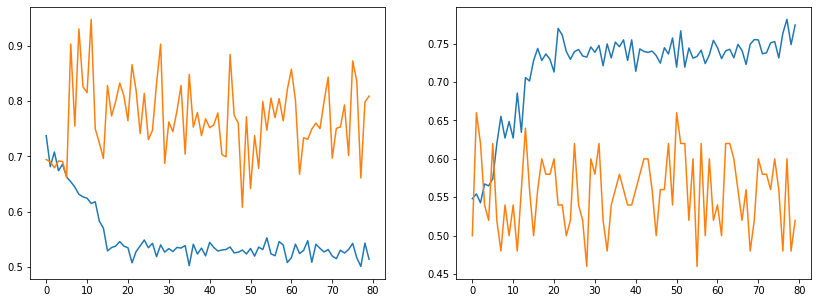

In [22]:
import seaborn as sns
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.lineplot(x=range(80), y=training_losses, ax=ax1, legend='full')
sns.lineplot(x=range(80), y=validation_losses, ax=ax1, legend='full')

sns.lineplot(x=range(80), y=training_accuracies, ax=ax2, legend='full')
sns.lineplot(x=range(80), y=validation_accuracies, ax=ax2, legend='full');